# Exercise 3.4.2  
Medium: Forecast the daily closing price of GOOGL  
Using the GOOGL dataset that we have worked with in this chapter, apply the forecasting techniques and measure their performance.  
1) Keep the last 5 days of data as a test set. The rest will be the training set.
2) Forecast the last 5 days using naïve forecasting methods and measure the MSE.  Which method is the best?
3) Plot your forecasts
4) Forecast the next timestep over the test set and measure the MSE. Did it decrease?
5) Plot your forecasts

In [1]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import importlib
import sys
import yfinance as yf

import warnings
warnings.filterwarnings('ignore')

sys.path.append('../../My-Code/')

import timetools as tt

importlib.reload(tt)

<module 'timetools' from '../../My-Code/timetools.py'>

[*********************100%***********************]  1 of 1 completed


Date
2020-04-28    1233.670044
2020-04-29    1341.479980
2020-04-30    1348.660034
2020-05-01    1320.609985
2020-05-04    1326.800049
                 ...     
2021-04-22    2267.919922
2021-04-23    2315.300049
2021-04-26    2326.739990
2021-04-27    2307.120117
2021-04-28    2379.909912
Name: Adj Close, Length: 253, dtype: float64

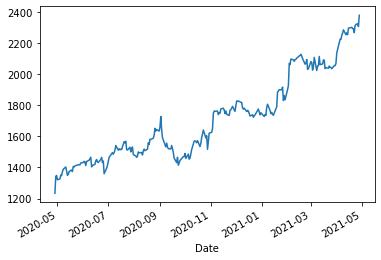

In [2]:
# Keep the last 5 days of data of Google dataset as test dataset.  The rest as train dataset
# Google: April 28, 2020, and April 27, 2021

google = yf.download('GOOG')
google = google.loc['2020-04-28': '2021-04-28']['Adj Close']
google.plot()
display(google)
train, test = google[:-5], google.tail(5)

In [3]:
# 2) Forecast the last 5 days using naïve forecasting methods and measure the MSE.  Which method is the best?

sample_size = len(google)

index_vals = np.arange(len(train) + 1, sample_size + 1, 1)
df_pred = pd.DataFrame(test)
df_pred['pred_mean'] = np.mean(train)
df_pred['pred_last_value'] = train[len(train)-1]

# drift
delta_x = len(train) - 0
delta_y = train[-1] - train[0]
drift = delta_y / delta_x
df_pred['drift'] = index_vals * drift + train[0]     # y = a + b*x
display(df_pred)


,Adj Close,pred_mean,pred_last_value,drift
Date,,,,
2021-04-22,2267.919922,1699.006911,2293.290039,2297.562700
2021-04-23,2315.300049,1699.006911,2293.290039,2301.835362
2021-04-26,2326.739990,1699.006911,2293.290039,2306.108023
2021-04-27,2307.120117,1699.006911,2293.290039,2310.380684
2021-04-28,2379.909912,1699.006911,2293.290039,2314.653345


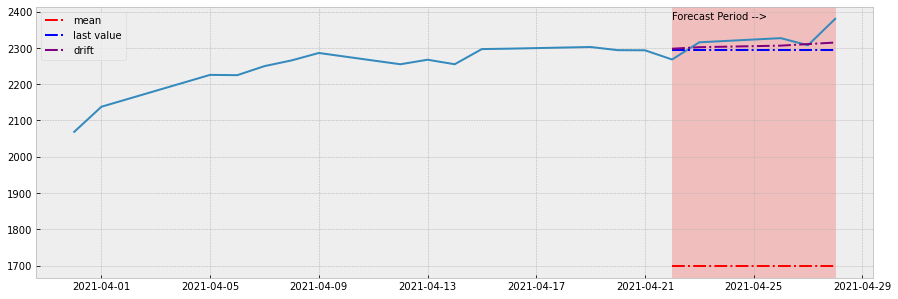

In [4]:
# 3) Plot your forecasts

plt.style.use('bmh')
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(google.tail(20))
ax.axvspan(df_pred.iloc[0:1].index, df_pred.iloc[4:5].index, color='red', alpha=0.2)
ax.plot(df_pred['pred_mean'], color='red', ls='-.', label='mean')
ax.plot(df_pred['pred_last_value'], color='blue', ls='-.', label='last value')
ax.plot(df_pred['drift'], color='purple', ls='-.', label='drift')
ax.text(x=df_pred.iloc[0:1].index, y=max(np.max(train)+3, np.max(test)), s='Forecast Period -->')
plt.legend()
plt.show(); 

In [5]:
# measure MSE

from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(df_pred['Adj Close'], df_pred.pred_mean)
mse_last = mean_squared_error(df_pred['Adj Close'], df_pred.pred_last_value)
mse_drift = mean_squared_error(df_pred['Adj Close'], df_pred.drift)

results = pd.DataFrame({'Error': [mse_mean, mse_last, mse_drift]}, index=['mse mean', 'mse last value', 'mse drift'])
results

,Error
mse mean,386191.726274
mse last value,1988.251215
mse drift,1150.944197


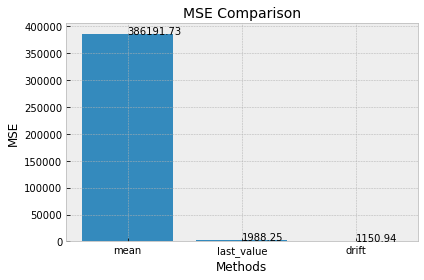

In [6]:
fig, ax = plt.subplots()

ax.bar(
    ['mean', 'last_value', 'drift'], 
    [mse_mean, mse_last, mse_drift], 
    width=0.8)

ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_title('MSE Comparison', fontsize=14)
ax.text(y=mse_mean+2, x=0, s=round(mse_mean, 2))
ax.text(y=mse_last+2, x=1, s=round(mse_last, 2))
ax.text(y=mse_drift+2, x=2, s=round(mse_drift, 2))

plt.tight_layout()

In [7]:
# 4) Forecast the next timestep over the test set and measure the MSE. Did it decrease?
df_pred_2 = pd.DataFrame(google.copy())
df_pred_2.set_index(np.arange(0,len(google)),inplace=True)
df_pred_2['one-step'] = df_pred_2['Adj Close'].shift(1)

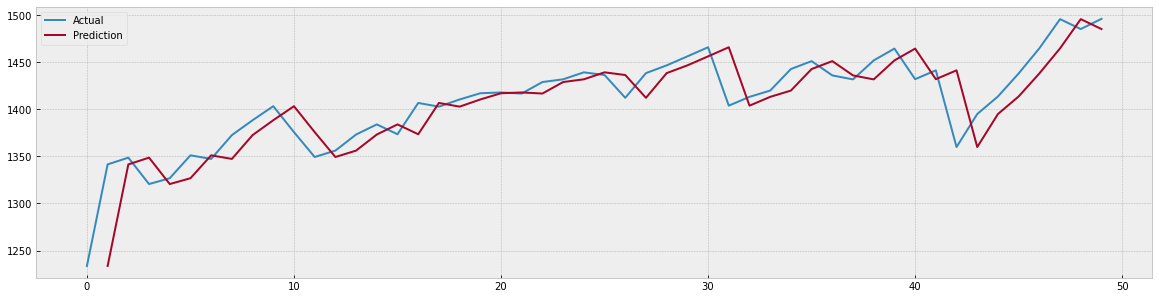

In [8]:
fig, ax = plt.subplots(figsize=(20, 5))
plt.style.use('bmh')
ax.plot(df_pred_2['Adj Close'].head(50), label='Actual')
ax.plot(df_pred_2['one-step'].head(50), label='Prediction')
plt.legend()
plt.show(); plt.style.use('default')

In [9]:
mse_one_step = mean_squared_error(df_pred_2['Adj Close'].tail(5), 
    df_pred_2['one-step'].tail(5)) 
print(mse_one_step)

1740.537039744854


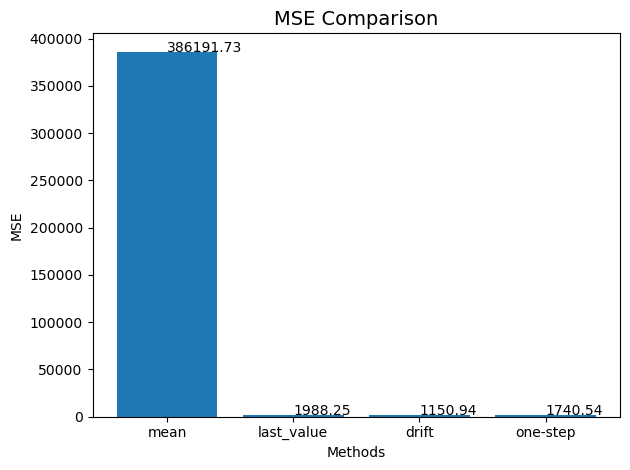

In [10]:
fig, ax = plt.subplots()

ax.bar(
    ['mean', 'last_value', 'drift', 'one-step'], 
    [mse_mean, mse_last, mse_drift, mse_one_step], 
    width=0.8)

ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_title('MSE Comparison', fontsize=14)
ax.text(y=mse_mean+2, x=0, s=round(mse_mean, 2))
ax.text(y=mse_last+2, x=1, s=round(mse_last, 2))
ax.text(y=mse_drift+2, x=2, s=round(mse_drift, 2))
ax.text(y=mse_one_step+2, x=3, s=round(mse_one_step, 2))

plt.tight_layout()